# HR Analytics - Analyse des Performances Employés
> **Dataset :** HRDataset_v14.csv (311 employés · 36 variables)  
> **Workflow :** Data Cleaning → Statistiques Descriptives → Visualisations → Détection Outliers → Insights Business

---

## 0. Imports & Configuration

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams.update({
    'figure.dpi': 120,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
})

print('Environnement prêt.')

Environnement prêt.


---
## 1. Chargement & Nettoyage des données

In [3]:
df_raw = pd.read_csv('HRDataset_v14.csv')
print(f'Dimensions brutes : {df_raw.shape[0]} lignes × {df_raw.shape[1]} colonnes')
df_raw.head(3)

Dimensions brutes : 311 lignes × 36 colonnes


,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,...,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,...,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,...,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3


In [30]:
df = df_raw.copy()

# --- Nettoyage des espaces dans les chaînes ---------------------------------------
df.columns = df.columns.str.strip()
str_cols = df.select_dtypes(include='object').columns
df[str_cols] = df[str_cols].apply(lambda c: c.str.strip())

# --- Conversion des dates ----------------------------------------------------------
for col in ['DateofHire', 'DateofTermination', 'DOB', 'LastPerformanceReview_Date']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# --- Ancienneté (années depuis l'embauche, référence 2019-01-01) -------------------
REF_DATE = pd.Timestamp('2019-01-01')
df['Seniority'] = ((REF_DATE - df['DateofHire']).dt.days / 365.25).round(1)

# --- Encodage numérique du PerformanceScore ----------------------------------------
PERF_MAP = {'PIP': 1, 'Needs Improvement': 2, 'Fully Meets': 3, 'Exceeds': 4}
df['PerformanceScore_Label'] = df['PerformanceScore']
df['PerformanceScore']       = df['PerformanceScore'].map(PERF_MAP)
print('Encodage PerformanceScore :', PERF_MAP)

# --- Valeurs manquantes ------------------------------------------------------------
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print('\nValeurs manquantes :')
print(missing)

print(f'\n✅ Dataset nettoyé : {df.shape[0]} lignes × {df.shape[1]} colonnes')

Encodage PerformanceScore : {'PIP': 1, 'Needs Improvement': 2, 'Fully Meets': 3, 'Exceeds': 4}

Valeurs manquantes :
DateofTermination    207
ManagerID              8
dtype: int64

✅ Dataset nettoyé : 311 lignes × 38 colonnes


In [31]:
# --- Aperçu final -----------------------------------------------------
df[['Employee_Name','Department','Position','PerformanceScore_Label',
    'PerformanceScore','Salary','Seniority','Sex','Absences']].head(5)

,Employee_Name,Department,Position,PerformanceScore_Label,PerformanceScore,Salary,Seniority,Sex,Absences
0,"Adinolfi, Wilson K",Production,Production Technician I,Exceeds,4,62506,7.5,M,1
1,"Ait Sidi, Karthikeyan",IT/IS,Sr. DBA,Fully Meets,3,104437,3.8,M,17
2,"Akinkuolie, Sarah",Production,Production Technician II,Fully Meets,3,64955,7.5,F,3
3,"Alagbe,Trina",Production,Production Technician I,Fully Meets,3,64991,11.0,F,15
4,"Anderson, Carol",Production,Production Technician I,Fully Meets,3,50825,7.5,F,2


---
## 2. Statistiques Descriptives

In [32]:
# --- Vue d'ensemble globale -------------------------------------------------
NUM_COLS = ['PerformanceScore', 'Salary', 'Seniority', 'EngagementSurvey',
            'EmpSatisfaction', 'Absences', 'DaysLateLast30', 'SpecialProjectsCount']

print('=== description() globale ===')
df[NUM_COLS].describe().round(2)

=== description() globale ===


,PerformanceScore,Salary,Seniority,EngagementSurvey,EmpSatisfaction,Absences,DaysLateLast30,SpecialProjectsCount
count,311.00,311.00,311.00,311.00,311.00,311.00,311.00,311.00
mean,2.98,69020.68,5.91,4.11,3.89,10.24,0.41,1.22
std,0.59,25156.64,1.95,0.79,0.91,5.85,1.29,2.35
min,1.00,45046.00,0.50,1.12,1.00,1.00,0.00,0.00
25%,3.00,55501.50,4.30,3.69,3.00,5.00,0.00,0.00
50%,3.00,62810.00,5.90,4.28,4.00,10.00,0.00,0.00
75%,3.00,72036.00,7.50,4.70,5.00,15.00,0.00,0.00
max,4.00,250000.00,13.00,5.00,5.00,20.00,6.00,8.00


In [33]:
# --- Métriques enrichies (IQR, mode, skewness, kurtosis) --------------------
def metriques_enrichies(series, nom):
    s = series.dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return {
        'Variable'   : nom,
        'N'          : len(s),
        'Moyenne'    : round(s.mean(), 2),
        'Médiane'    : round(s.median(), 2),
        'Mode'       : round(s.mode().iloc[0], 2) if not s.mode().empty else np.nan,
        'Écart-type' : round(s.std(), 2),
        'Variance'   : round(s.var(), 2),
        'Q1'         : round(q1, 2),
        'Q3'         : round(q3, 2),
        'IQR'        : round(iqr, 2),
        'Min'        : round(s.min(), 2),
        'Max'        : round(s.max(), 2),
        'Skewness'   : round(s.skew(), 2),
        'Kurtosis'   : round(s.kurt(), 2),
    }

stats_df = pd.DataFrame([metriques_enrichies(df[c], c) for c in NUM_COLS]).set_index('Variable')
print('=== Métriques descriptives enrichies ===')
stats_df

=== Métriques descriptives enrichies ===


,N,Moyenne,Médiane,Mode,Écart-type,Variance,Q1,Q3,IQR,Min,Max,Skewness,Kurtosis
Variable,,,,,,,,,,,,,
PerformanceScore,311,2.98,3.00,3.0,0.59,3.400000e-01,3.00,3.0,0.00,1.00,4.0,-1.25,4.05
Salary,311,69020.68,62810.00,57815.0,25156.64,6.328564e+08,55501.50,72036.0,16534.50,45046.00,250000.0,3.31,15.45
Seniority,311,5.91,5.90,7.5,1.95,3.810000e+00,4.30,7.5,3.20,0.50,13.0,0.15,0.10
EngagementSurvey,311,4.11,4.28,5.0,0.79,6.200000e-01,3.69,4.7,1.01,1.12,5.0,-1.12,1.16
EmpSatisfaction,311,3.89,4.00,3.0,0.91,8.300000e-01,3.00,5.0,2.00,1.00,5.0,-0.22,-0.76
Absences,311,10.24,10.00,4.0,5.85,3.425000e+01,5.00,15.0,10.00,1.00,20.0,0.03,-1.30
DaysLateLast30,311,0.41,0.00,0.0,1.29,1.680000e+00,0.00,0.0,0.00,0.00,6.0,3.14,8.83
SpecialProjectsCount,311,1.22,0.00,0.0,2.35,5.520000e+00,0.00,0.0,0.00,0.00,8.0,1.54,0.64


In [34]:
# --- PerformanceScore par Département -----------------------------------
dept_stats = (df.groupby('Department')['PerformanceScore']
                .describe()
                .round(2)
                .sort_values('mean', ascending=False))
print('=== PerformanceScore par Département ===')
display(dept_stats)

=== PerformanceScore par Département ===


,count,mean,std,min,25%,50%,75%,max
Department,,,,,,,,
Software Engineering,11.0,3.09,0.54,2.0,3.0,3.0,3.0,4.0
IT/IS,50.0,3.06,0.47,1.0,3.0,3.0,3.0,4.0
Executive Office,1.0,3.00,NaN,3.0,3.0,3.0,3.0,3.0
Admin Offices,9.0,3.00,0.00,3.0,3.0,3.0,3.0,3.0
Production,209.0,2.98,0.60,1.0,3.0,3.0,3.0,4.0
Sales,31.0,2.77,0.76,1.0,3.0,3.0,3.0,4.0


In [36]:
# --- Salary par Département ---------------------------------------
salary_dept = (df.groupby('Department')['Salary']
                 .agg(['mean','median','std','min','max','count'])
                 .round(0)
                 .sort_values('median', ascending=False))
print('=== Salary par Département ===')
display(salary_dept)

=== Salary par Département ===


,mean,median,std,min,max,count
Department,,,,,,
Executive Office,250000.0,250000.0,NaN,250000,250000,1
Software Engineering,94989.0,95660.0,9567.0,77692,108987,11
IT/IS,97065.0,92328.0,33210.0,50178,220450,50
Sales,69061.0,65310.0,21271.0,55875,180000,31
Admin Offices,71792.0,63003.0,21706.0,49920,106367,9
Production,59954.0,59472.0,11423.0,45046,170500,209


In [37]:
# --- Top 15 Positions par Performance Moyenne ---------------------------------
pos_stats = (df.groupby('Position')['PerformanceScore']
               .agg(['mean','median','std','count'])
               .round(2)
               .sort_values('mean', ascending=False)
               .head(15))
print('=== Top 15 Positions par Performance Moyenne ===')
display(pos_stats)

=== Top 15 Positions par Performance Moyenne ===


,mean,median,std,count
Position,,,,
CIO,4.00,4.0,NaN,1
IT Director,4.00,4.0,NaN,1
Director of Operations,4.00,4.0,NaN,1
IT Manager - Support,4.00,4.0,NaN,1
Data Analyst,3.25,3.0,0.46,8
IT Support,3.12,3.0,0.35,8
Software Engineer,3.10,3.0,0.57,10
Director of Sales,3.00,3.0,NaN,1
BI Developer,3.00,3.0,0.00,4


---
## 3. Visualisations - Distributions

### 3.1 Histogrammes - PerformanceScore & Salary

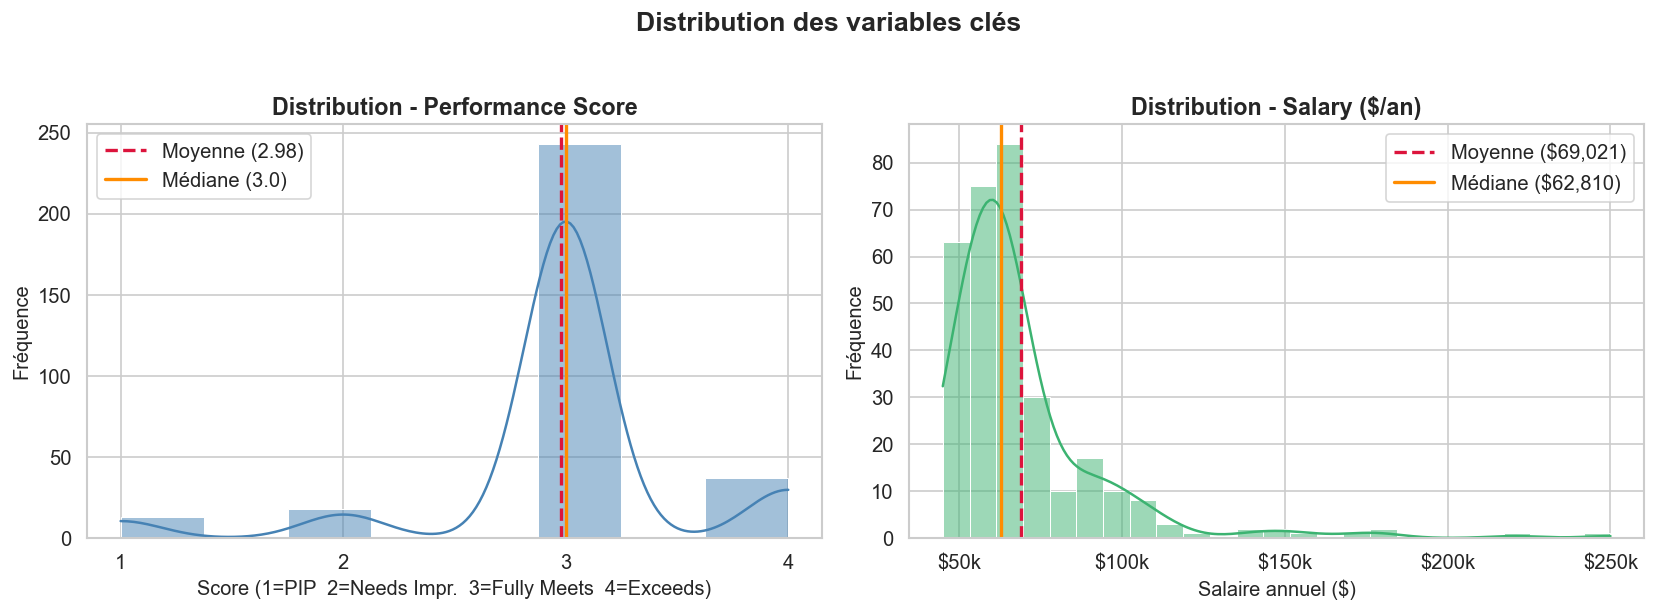

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Distribution des variables clés', fontsize=16, fontweight='bold', y=1.02)

# PerformanceScore
ax = axes[0]
sns.histplot(df['PerformanceScore'].dropna(), kde=True, ax=ax,
             color='steelblue', bins=8, edgecolor='white', linewidth=0.6)
ax.axvline(df['PerformanceScore'].mean(),   color='crimson',   linestyle='--', lw=2,
           label=f"Moyenne ({df['PerformanceScore'].mean():.2f})")
ax.axvline(df['PerformanceScore'].median(), color='darkorange', linestyle='-', lw=2,
           label=f"Médiane ({df['PerformanceScore'].median():.1f})")
ax.set_title('Distribution - Performance Score')
ax.set_xlabel('Score (1=PIP  2=Needs Impr.  3=Fully Meets  4=Exceeds)')
ax.set_ylabel('Fréquence')
ax.set_xticks([1, 2, 3, 4])
ax.legend()

# Salary
ax = axes[1]
sns.histplot(df['Salary'].dropna(), kde=True, ax=ax,
             color='mediumseagreen', bins=25, edgecolor='white', linewidth=0.6)
ax.axvline(df['Salary'].mean(),   color='crimson',   linestyle='--', lw=2,
           label=f"Moyenne (${df['Salary'].mean():,.0f})")
ax.axvline(df['Salary'].median(), color='darkorange', linestyle='-', lw=2,
           label=f"Médiane (${df['Salary'].median():,.0f})")
ax.set_title('Distribution - Salary ($/an)')
ax.set_xlabel('Salaire annuel ($)')
ax.set_ylabel('Fréquence')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax.legend()

plt.tight_layout()
plt.savefig('hist_distributions.png', bbox_inches='tight')
plt.show()

#### Interprétation 
##### Histogramme — PerformanceScore : 
La distribution est fortement concentrée sur le score 3 (Fully Meets) avec une légère asymétrie négative, la moyenne (2,98) étant très proche mais inférieure à la médiane (3,0). Les scores extrêmes (PIP et Exceeds) restent minoritaires, révélant un profil bimodal discret avec un pic majeur en 3 et un plateau secondaire en 4.

##### Histogramme — Salary ($/an) : 
La distribution présente une asymétrie droite marquée, avec la majorité des salaires concentrés entre 45k et 80k et une queue longue s'étendant jusqu'à 250k. L'écart entre la moyenne (69 021) et la médiane (62 810) confirme l'influence de quelques salaires très élevés qui tirent la moyenne vers le haut.

### 3.2 Barres & Pie - Répartition des catégories de performance

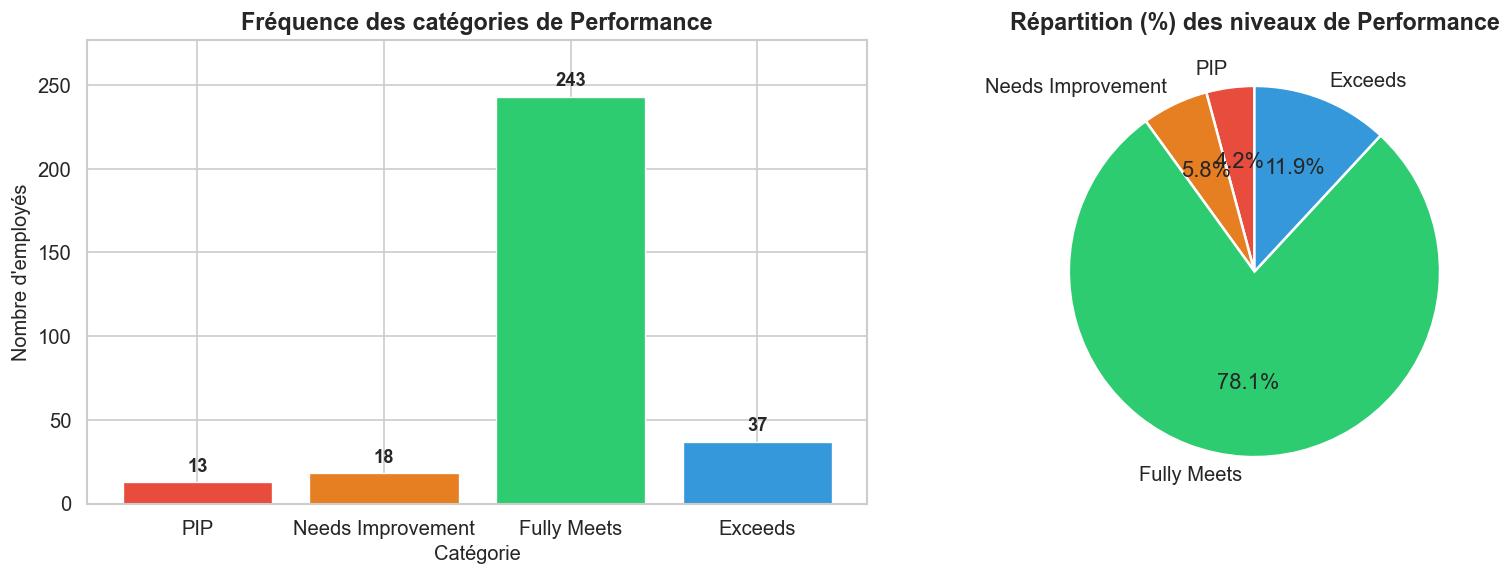

In [39]:
ORDER   = ['PIP', 'Needs Improvement', 'Fully Meets', 'Exceeds']
PALETTE = ['#e74c3c', '#e67e22', '#2ecc71', '#3498db']
counts  = df['PerformanceScore_Label'].value_counts()
vals    = [counts.get(o, 0) for o in ORDER]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Barres
bars = axes[0].bar(ORDER, vals, color=PALETTE, edgecolor='white', linewidth=0.8)
axes[0].bar_label(bars, padding=4, fontsize=11, fontweight='bold')
axes[0].set_title('Fréquence des catégories de Performance')
axes[0].set_xlabel('Catégorie')
axes[0].set_ylabel("Nombre d'employés")
axes[0].set_ylim(0, max(vals) * 1.14)

# Pie chart
axes[1].pie(vals, labels=ORDER, colors=PALETTE,
            autopct='%1.1f%%', startangle=90,
            wedgeprops=dict(edgecolor='white', linewidth=1.5))
axes[1].set_title('Répartition (%) des niveaux de Performance')

plt.tight_layout()
plt.savefig('barres_pie_performance.png', bbox_inches='tight')
plt.show()

#### Interprétation 
Fully Meets domine massivement avec 243 employés, soit 78,1% de l'effectif total, tandis que les catégories extrêmes restent très marginales : Exceeds (37 employés, 11,9%), Needs Improvement (18 employés, 5,8%) et PIP (13 employés, 4,2%). La répartition confirme une forte homogénéité des évaluations, avec seulement 16,1% des employés se distinguant positivement ou négativement de la norme centrale.

### 3.3 Boxplots - Performance & Salary par Département

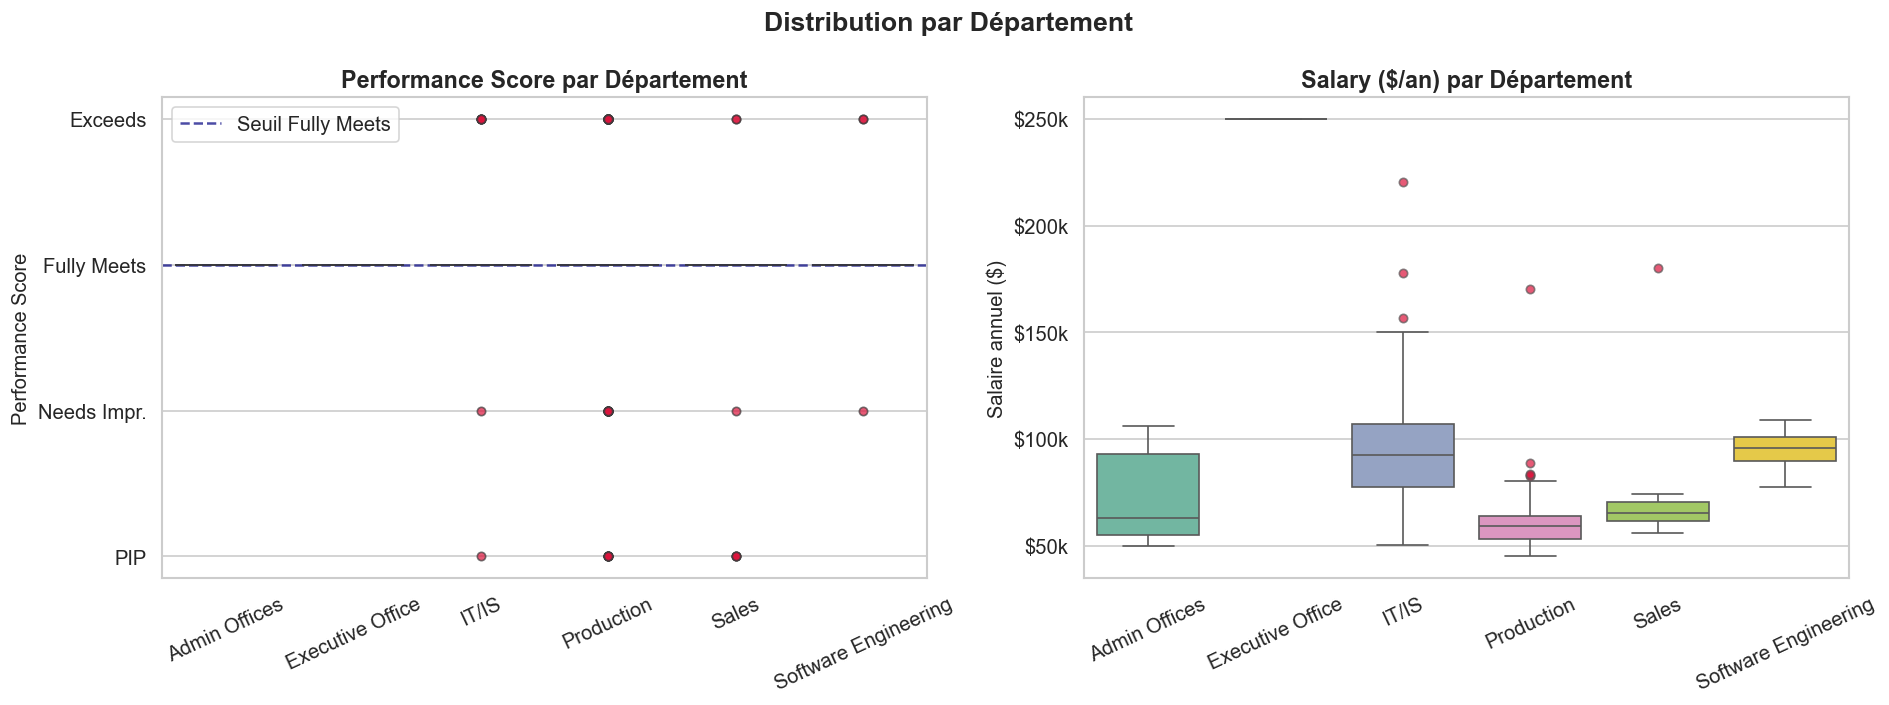

In [40]:
dept_order = (df.groupby('Department')['PerformanceScore']
                .median()
                .sort_values(ascending=False)
                .index.tolist())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Distribution par Département', fontsize=16, fontweight='bold')

# Performance
sns.boxplot(data=df, x='Department', y='PerformanceScore',
            order=dept_order, palette='muted', ax=axes[0],
            flierprops=dict(marker='o', markerfacecolor='crimson', markersize=5, alpha=0.7))
axes[0].axhline(3, color='navy', linestyle='--', lw=1.5, alpha=0.7, label='Seuil Fully Meets')
axes[0].set_title('Performance Score par Département')
axes[0].set_xlabel('')
axes[0].set_ylabel('Performance Score')
axes[0].set_yticks([1, 2, 3, 4])
axes[0].set_yticklabels(['PIP', 'Needs Impr.', 'Fully Meets', 'Exceeds'])
axes[0].tick_params(axis='x', rotation=25)
axes[0].legend()

# Salary
sns.boxplot(data=df, x='Department', y='Salary',
            order=dept_order, palette='Set2', ax=axes[1],
            flierprops=dict(marker='o', markerfacecolor='crimson', markersize=5, alpha=0.7))
axes[1].set_title('Salary ($/an) par Département')
axes[1].set_xlabel('')
axes[1].set_ylabel('Salaire annuel ($)')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
axes[1].tick_params(axis='x', rotation=25)

plt.tight_layout()
plt.savefig('boxplots_departements.png', bbox_inches='tight')
plt.show()

#### Interprétation : 
Tous les départements performent de manière similaire, avec une majorité d'employés évalués Fully Meets, et quelques cas isolés très bons (Exceeds) ou en difficulté (PIP). Par contre, les salaires varient fortement selon les départements : IT/IS et Software Engineering sont les mieux payés (autour de $90k–$100k), alors que la Production reste la moins bien rémunérée (~$55k–$65k), malgré des performances équivalentes aux autres.

### 3.4 Scatter plots - Corrélations croisées

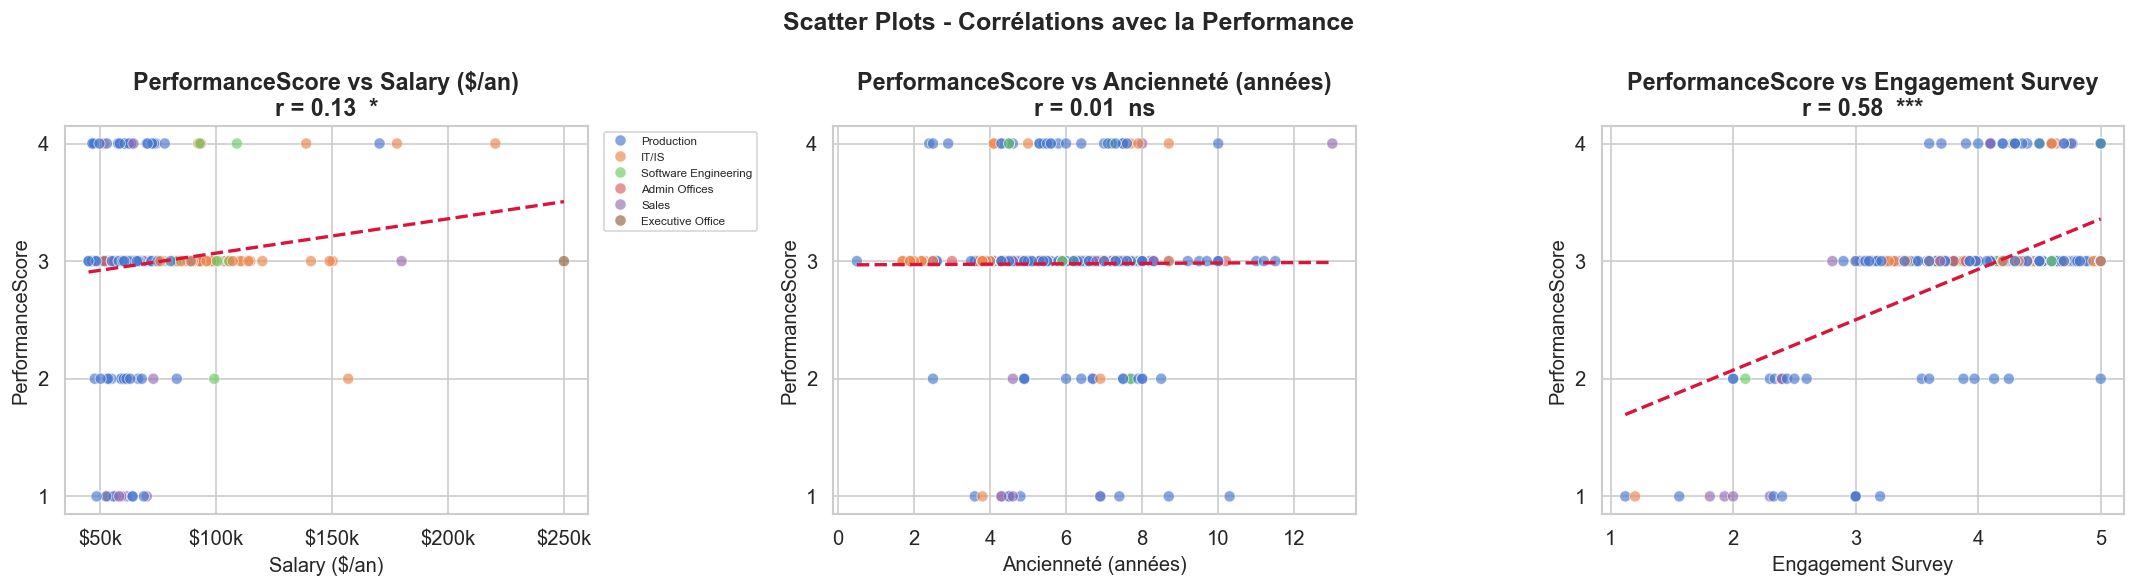

In [41]:
SCATTER_PAIRS = [
    ('Salary',           'PerformanceScore', 'Salary ($/an)'),
    ('Seniority',        'PerformanceScore', 'Ancienneté (années)'),
    ('EngagementSurvey', 'PerformanceScore', 'Engagement Survey'),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Scatter Plots - Corrélations avec la Performance', fontsize=15, fontweight='bold')

for ax, (x_col, y_col, x_label) in zip(axes, SCATTER_PAIRS):
    data = df[[x_col, y_col, 'Department']].dropna()
    r, p = stats.pearsonr(data[x_col], data[y_col])

    sns.scatterplot(data=data, x=x_col, y=y_col,
                    hue='Department', alpha=0.65, s=45, ax=ax,
                    legend=(x_col == 'Salary'))

    m, b = np.polyfit(data[x_col], data[y_col], 1)
    xr = np.linspace(data[x_col].min(), data[x_col].max(), 200)
    ax.plot(xr, m * xr + b, color='crimson', lw=2, linestyle='--')

    sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns'))
    ax.set_title(f'{y_col} vs {x_label}\nr = {r:.2f}  {sig}')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_col)
    ax.set_yticks([1, 2, 3, 4])
    if x_col == 'Salary':
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=7)

plt.tight_layout()
plt.savefig('scatter_correlations.png', bbox_inches='tight')
plt.show()

#### Interprétation : 
Le salaire a une très faible influence sur la performance (r = 0,13), ce qui confirme qu'être mieux payé ne signifie pas forcément mieux performer. L'ancienneté n'a quasiment aucun lien avec la performance (r = 0,01), indiquant que les années d'expérience dans l'entreprise ne font pas de différence. En revanche, l'engagement des employés est le facteur le plus lié à la performance (r = 0,58) : plus un employé est engagé, plus sa performance tend à être élevée.

### 3.5 Heatmap de corrélation

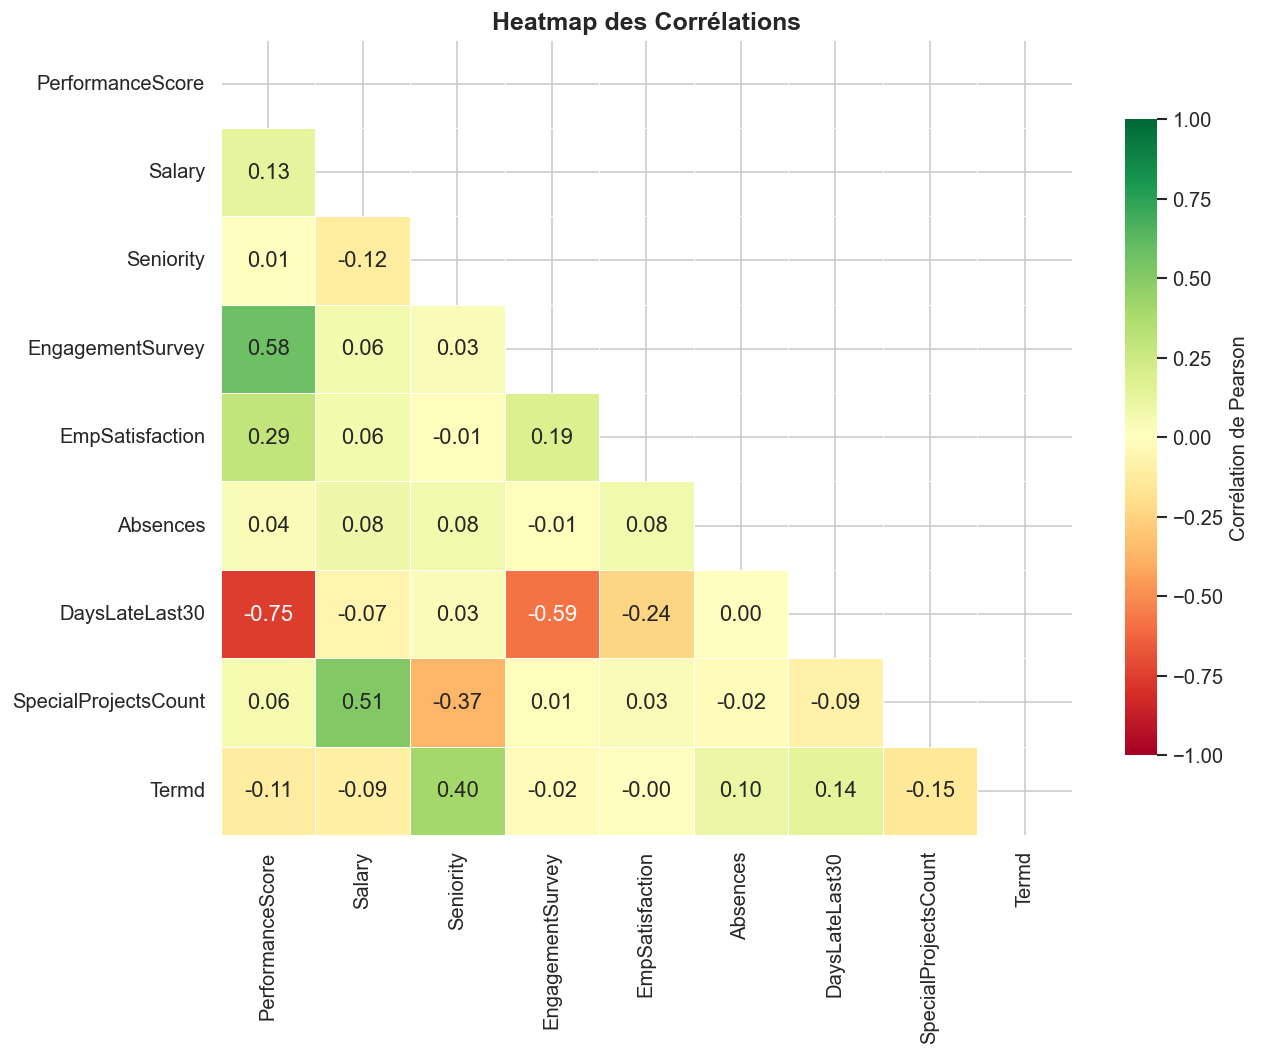


 Corrélations avec PerformanceScore (|r| > 0.15) :
DaysLateLast30      0.752
EngagementSurvey    0.577
EmpSatisfaction     0.291
Name: PerformanceScore, dtype: float64


In [42]:
CORR_COLS = ['PerformanceScore', 'Salary', 'Seniority', 'EngagementSurvey',
             'EmpSatisfaction', 'Absences', 'DaysLateLast30',
             'SpecialProjectsCount', 'Termd']

corr_matrix = df[CORR_COLS].corr()

fig, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='RdYlGn', vmin=-1, vmax=1, center=0,
            linewidths=0.5, ax=ax,
            cbar_kws={'label': 'Corrélation de Pearson', 'shrink': 0.8})
ax.set_title('Heatmap des Corrélations', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('heatmap_correlations.png', bbox_inches='tight')
plt.show()

print('\n Corrélations avec PerformanceScore (|r| > 0.15) :')
sig = corr_matrix['PerformanceScore'].drop('PerformanceScore').abs().sort_values(ascending=False)
print(sig[sig > 0.15].round(3))

#### Interprétation : 
Trois variables se démarquent comme les plus liées à la performance : le nombre de jours de retard (DaysLateLast30) est le facteur le plus fortement corrélé négativement (r = -0,75), signifie qu'un employé qui arrive souvent en retard a tendance à très mal performer. À l'opposé, l'engagement (r = 0,58) et la satisfaction (r = 0,29) sont positivement liés à la performance, un employé engagé et satisfait performe mieux. Le salaire, l'ancienneté et les absences n'ont quasiment aucun lien avec la performance (r proches de 0).

---
## 4. Détection des Outliers (règle 1.5 × IQR)

In [43]:
def detecter_outliers(df, col):
    s = df[col].dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    mask = (df[col] < low) | (df[col] > high)
    df_out = df[mask].copy()
    df_out['Outlier_Type'] = np.where(df[col][mask] > high, '🔺 Haut', '🔻 Bas')
    return df_out, low, high, q1, q3, iqr

# --- Tableau récapitulatif -----------------------------------------------------
TARGET_COLS   = ['PerformanceScore', 'Salary']
outlier_store = {}
summary_rows  = []

for col in TARGET_COLS:
    df_out, low, high, q1, q3, iqr = detecter_outliers(df, col)
    outlier_store[col] = df_out
    pct = len(df_out) / len(df) * 100
    summary_rows.append({
        'Variable'        : col,
        'Q1'              : round(q1, 2),
        'Q3'              : round(q3, 2),
        'IQR'             : round(iqr, 2),
        'Borne Basse'     : round(low, 2),
        'Borne Haute'     : round(high, 2),
        'N Outliers Bas'  : int((df[col] < low).sum()),
        'N Outliers Hauts': int((df[col] > high).sum()),
        'N Total'         : len(df_out),
        'Taux (%)'        : round(pct, 1),
        'Alerte'          : '⚠️ Systémique' if pct >= 10 else '✅ Normal',
    })

summary_df = pd.DataFrame(summary_rows).set_index('Variable')
print('=== Tableau récapitulatif des Outliers (1.5 × IQR) ===')
display(summary_df)

=== Tableau récapitulatif des Outliers (1.5 × IQR) ===


,Q1,Q3,IQR,Borne Basse,Borne Haute,N Outliers Bas,N Outliers Hauts,N Total,Taux (%),Alerte
Variable,,,,,,,,,,
PerformanceScore,3.0,3.0,0.0,3.00,3.00,31,37,68,21.9,⚠️ Systémique
Salary,55501.5,72036.0,16534.5,30699.75,96837.75,0,29,29,9.3,✅ Normal


In [45]:
# --- Détail des outliers ---------------------------------------------------------
SHOW_COLS = ['Employee_Name', 'Department', 'Position', 'PerformanceScore_Label',
             'PerformanceScore', 'Salary', 'Seniority', 'Absences', 'Outlier_Type']

print('=== Employés Outliers - PerformanceScore ===')
display(outlier_store['PerformanceScore'][SHOW_COLS].sort_values('PerformanceScore'))

print('\n=== Employés Outliers - Salary ===')
display(outlier_store['Salary'][['Employee_Name','Department','Position',
                                  'Salary','PerformanceScore_Label','Seniority','Outlier_Type']]
        .sort_values('Salary', ascending=False))

=== Employés Outliers - PerformanceScore ===


,Employee_Name,Department,Position,PerformanceScore_Label,PerformanceScore,Salary,Seniority,Absences,Outlier_Type
69,"Desimone, Carl",Production,Production Technician I,PIP,1,53189,4.5,9,🔻 Bas
72,"Dietrich, Jenna",Sales,Area Sales Manager,PIP,1,59231,6.9,17,🔻 Bas
67,"Delarge, Alex",Sales,Area Sales Manager,PIP,1,61568,4.3,5,🔻 Bas
112,"Gonzalez, Juan",Production,Production Technician II,PIP,1,68898,8.7,10,🔻 Bas
90,"Fernandes, Nilson",Production,Production Technician I,PIP,1,64057,3.6,15,🔻 Bas
...,...,...,...,...,...,...,...,...,...
5,"Anderson, Linda",Production,Production Technician I,Exceeds,4,57568,7.0,15,🔺 Haut
293,"Volk, Colleen",Production,Production Technician I,Exceeds,4,49773,7.3,18,🔺 Haut
289,"Veera, Abdellah",Production,Production Technician I,Exceeds,4,58523,6.4,15,🔺 Haut
304,"Winthrop, Jordan",Production,Production Technician II,Exceeds,4,70507,6.0,7,🔺 Haut



=== Employés Outliers - Salary ===


,Employee_Name,Department,Position,Salary,PerformanceScore_Label,Seniority,Outlier_Type
150,"King, Janet",Executive Office,President & CEO,250000,Fully Meets,6.5,🔺 Haut
308,"Zamora, Jennifer",IT/IS,CIO,220450,Exceeds,8.7,🔺 Haut
131,"Houlihan, Debra",Sales,Director of Sales,180000,Fully Meets,4.7,🔺 Haut
96,"Foss, Jason",IT/IS,IT Director,178000,Exceeds,7.7,🔺 Haut
55,"Corleone, Vito",Production,Director of Operations,170500,Exceeds,10.0,🔺 Haut
190,"Monroe, Peter",IT/IS,IT Manager - Infra,157000,Needs Improvement,6.9,🔺 Haut
240,"Roper, Katie",IT/IS,Data Architect,150290,Fully Meets,2.0,🔺 Haut
244,"Ruiz, Ricardo",IT/IS,IT Manager - DB,148999,Fully Meets,7.0,🔺 Haut
243,"Roup,Simon",IT/IS,IT Manager - DB,140920,Fully Meets,5.9,🔺 Haut
76,"Dougall, Eric",IT/IS,IT Manager - Support,138888,Exceeds,5.0,🔺 Haut


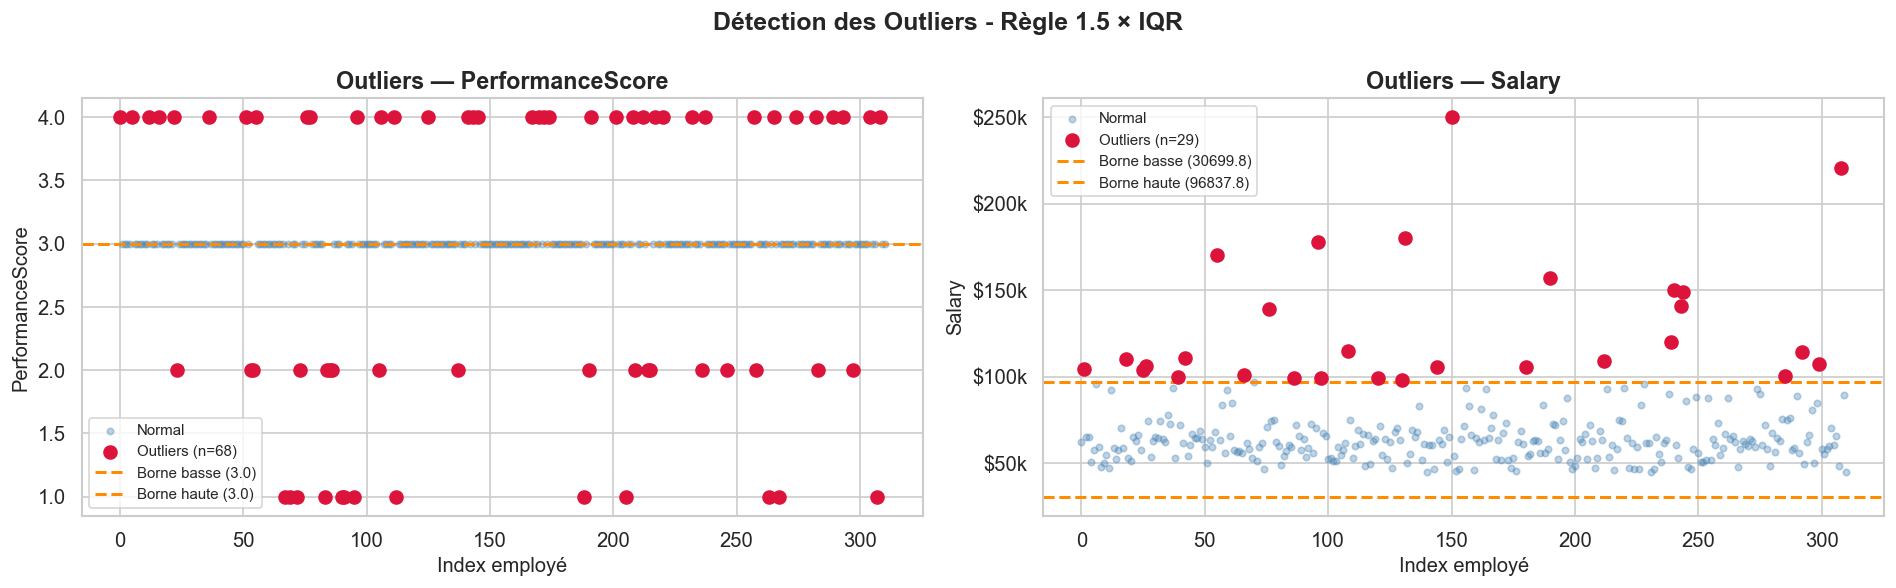

In [46]:
# --- Visualisation des outliers ------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Détection des Outliers - Règle 1.5 × IQR', fontsize=15, fontweight='bold')

for ax, col in zip(axes, TARGET_COLS):
    _, low, high, *_ = detecter_outliers(df, col)
    out_mask = (df[col] < low) | (df[col] > high)

    ax.scatter(range(len(df)), df[col], s=15, alpha=0.35, color='steelblue', label='Normal')
    ax.scatter(np.where(out_mask)[0], df[col][out_mask],
               s=60, color='crimson', zorder=5, label=f'Outliers (n={out_mask.sum()})')
    ax.axhline(low,  color='darkorange', linestyle='--', lw=1.8, label=f'Borne basse ({low:.1f})')
    ax.axhline(high, color='darkorange', linestyle='--', lw=1.8, label=f'Borne haute ({high:.1f})')
    ax.set_title(f'Outliers — {col}')
    ax.set_xlabel('Index employé')
    ax.set_ylabel(col)
    ax.legend(fontsize=9)
    if col == 'Salary':
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))

plt.tight_layout()
plt.savefig('outliers_detection.png', bbox_inches='tight')
plt.show()

#### Interprétation : 
Pour le Performance Score, les bornes haute et basse sont toutes les deux égales à 3,0 (car les scores sont discrets), ce qui classe automatiquement comme outliers tous les employés qui ne sont pas Fully Meets, soit 68 employés - dont les Exceeds (score 4), les Needs Improvement (score 2) et les PIP (score 1). Pour le Salary, 29 employés dépassent la borne haute de  96 837 , avec des salaires allant jusqu'à  250k , ce qui représente des cas clairement atypiques par rapport à la majorité de l'effectif concentrée sous les 100k.

### 4.1 Analyse des outliers par sous-groupes (biais)

In [20]:
_, low_p, high_p, *_ = detecter_outliers(df, 'Salary')
df['_is_outlier_salary'] = (df['Salary'] < low_p) | (df['Salary'] > high_p)

for grp_col in ['Department', 'Sex', 'RaceDesc']:
    taux = (df.groupby(grp_col)['_is_outlier_salary']
              .agg(['sum','count'])
              .rename(columns={'sum': 'N_outliers', 'count': 'N_total'})
              .assign(Taux_pct=lambda d: (d.N_outliers / d.N_total * 100).round(1))
              .sort_values('Taux_pct', ascending=False))
    print(f'\n=== Taux d\'outliers Salary par {grp_col} ===')
    display(taux)

df.drop(columns=['_is_outlier_salary'], inplace=True)


=== Taux d'outliers Salary par Department ===


,N_outliers,N_total,Taux_pct
Department,,,
Executive Office,1,1,100.0
Software Engineering,5,11,45.5
IT/IS,19,50,38.0
Admin Offices,2,9,22.2
Sales,1,31,3.2
Production,1,209,0.5



=== Taux d'outliers Salary par Sex ===


,N_outliers,N_total,Taux_pct
Sex,,,
M,13,135,9.6
F,16,176,9.1



=== Taux d'outliers Salary par RaceDesc ===


,N_outliers,N_total,Taux_pct
RaceDesc,,,
Black or African American,15,80,18.8
Asian,3,29,10.3
White,11,187,5.9
American Indian or Alaska Native,0,3,0.0
Hispanic,0,1,0.0
Two or more races,0,11,0.0


---
## 5. Insights Business

### 5.1 Performance médiane par département

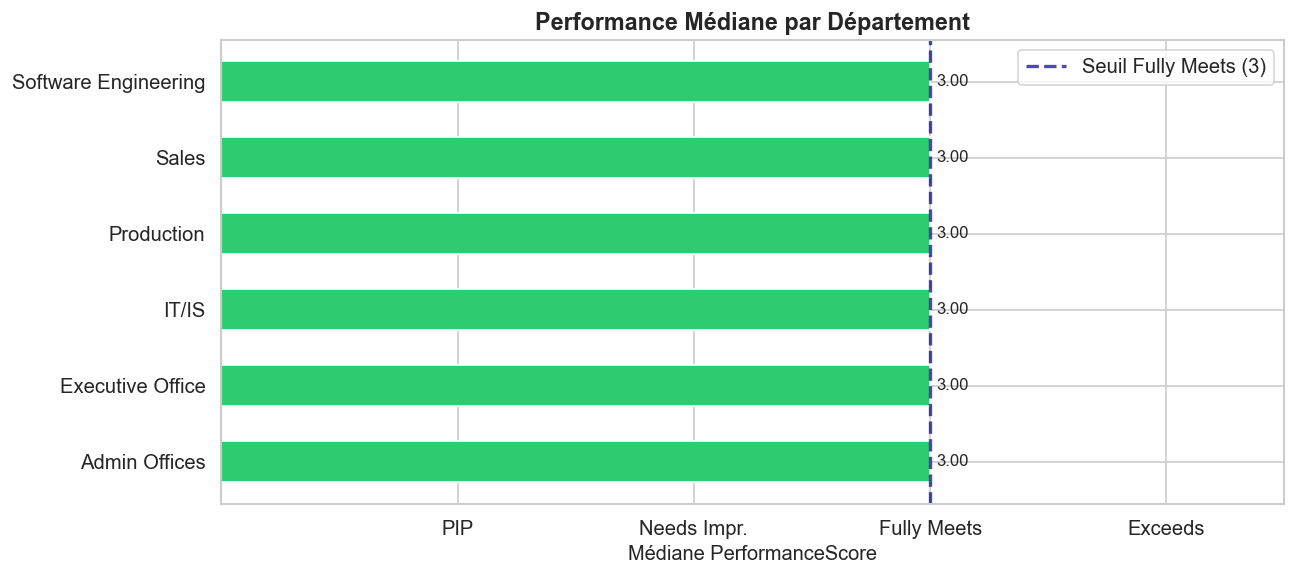

                      median  mean   std  count
Department                                     
Admin Offices            3.0  3.00  0.00      9
Executive Office         3.0  3.00   NaN      1
IT/IS                    3.0  3.06  0.47     50
Production               3.0  2.98  0.60    209
Sales                    3.0  2.77  0.76     31
Software Engineering     3.0  3.09  0.54     11


In [21]:
dept_perf = (df.groupby('Department')['PerformanceScore']
               .agg(['median','mean','std','count'])
               .round(2)
               .sort_values('median', ascending=True))

colors = ['#2ecc71' if m >= 3 else '#e74c3c' for m in dept_perf['median']]

fig, ax = plt.subplots(figsize=(11, 5))
bars = ax.barh(dept_perf.index, dept_perf['median'],
               color=colors, edgecolor='white', height=0.55)
ax.axvline(3, color='navy', linestyle='--', lw=2, alpha=0.7, label='Seuil Fully Meets (3)')
ax.bar_label(bars, padding=4, fmt='%.2f', fontsize=10)
ax.set_title('Performance Médiane par Département', fontsize=14, fontweight='bold')
ax.set_xlabel('Médiane PerformanceScore')
ax.set_xlim(0, 4.5)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['PIP', 'Needs Impr.', 'Fully Meets', 'Exceeds'])
ax.legend()
plt.tight_layout()
plt.savefig('insight_performance_departement.png', bbox_inches='tight')
plt.show()
print(dept_perf)

#### Interprétation : 
Tous les départements affichent une médiane identique de 3,0 (Fully Meets), ce qui confirme l'homogénéité globale des évaluations. Cependant, les moyennes et écarts-types révèlent des nuances importantes : Sales présente la moyenne la plus basse (2,77) avec le plus grand écart-type (0,76), indiquant une performance plus instable et variable, tandis que Production, le département le plus peuplé avec 209 employés, affiche également une moyenne légèrement sous le seuil (2,98) avec une dispersion notable (0,60). À l'inverse, Software Engineering (3,09) et IT/IS (3,06) sont les seuls départements dont la moyenne dépasse le seuil Fully Meets.

### 5.2 Salary selon le niveau de performance

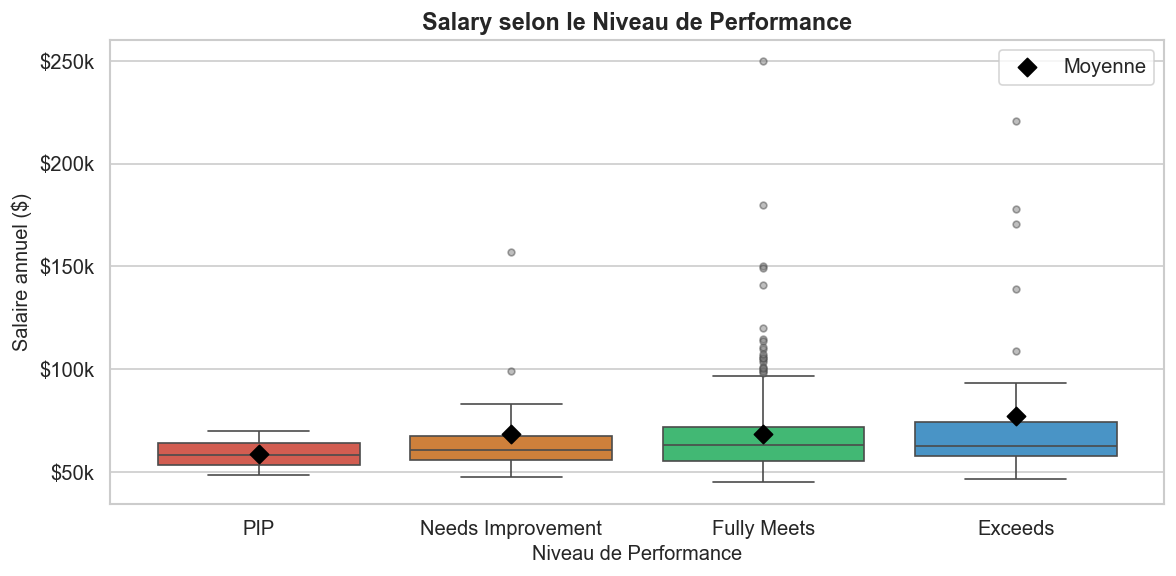

Salary moyen par niveau :
                           mean   median  count
PerformanceScore_Label                         
PIP                     58971.0  58273.0     13
Needs Improvement       68408.0  60881.0     18
Fully Meets             68367.0  63025.0    243
Exceeds                 77145.0  62910.0     37


In [22]:
ORDER_LABELS = ['PIP', 'Needs Improvement', 'Fully Meets', 'Exceeds']

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x='PerformanceScore_Label', y='Salary',
            order=ORDER_LABELS,
            palette=['#e74c3c','#e67e22','#2ecc71','#3498db'], ax=ax,
            flierprops=dict(marker='o', markerfacecolor='grey', markersize=4, alpha=0.5))

means = df.groupby('PerformanceScore_Label')['Salary'].mean().reindex(ORDER_LABELS)
ax.scatter(range(len(ORDER_LABELS)), means, color='black', s=60, zorder=5,
           label='Moyenne', marker='D')

ax.set_title('Salary selon le Niveau de Performance', fontsize=14, fontweight='bold')
ax.set_xlabel('Niveau de Performance')
ax.set_ylabel('Salaire annuel ($)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax.legend()
plt.tight_layout()
plt.savefig('insight_salary_performance.png', bbox_inches='tight')
plt.show()

print('Salary moyen par niveau :')
print(df.groupby('PerformanceScore_Label')['Salary']
        .agg(['mean','median','count']).round(0).reindex(ORDER_LABELS))

#### Interprétation :
Les médianes salariales sont très proches entre tous les niveaux (environs 58k–63k), ce qui confirme que le salaire est peu lié à la performance. La seule différence notable concerne les Exceeds, dont la moyenne (77 145) est plus élevée, mais cela s'explique surtout par quelques salaires outliers très élevés qui tirent la moyenne vers le haut, et non par une politique salariale réellement avantageuse pour les meilleurs performers. Les employés en PIP sont paradoxalement les mieux encadrés salarialement avec la distribution la plus resserrée (environs 50k–65k), sans grands écarts.

### 5.3 Ancienneté & Performance

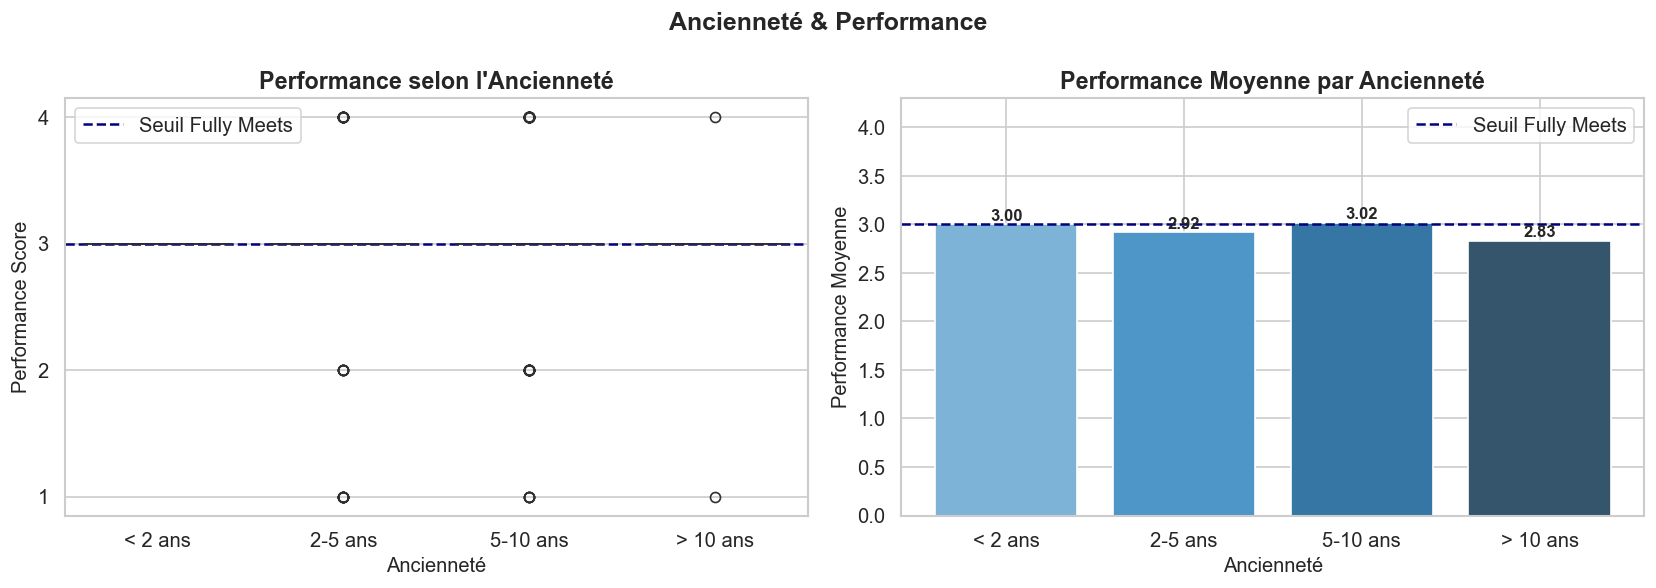

In [47]:
df['Seniority_Group'] = pd.cut(
    df['Seniority'],
    bins=[0, 2, 5, 10, 100],
    labels=['< 2 ans', '2-5 ans', '5-10 ans', '> 10 ans']
)
SEN_ORDER = ['< 2 ans', '2-5 ans', '5-10 ans', '> 10 ans']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Ancienneté & Performance', fontsize=15, fontweight='bold')

sns.boxplot(data=df, x='Seniority_Group', y='PerformanceScore',
            order=SEN_ORDER, palette='Blues_d', ax=axes[0])
axes[0].axhline(3, color='navy', linestyle='--', lw=1.5, label='Seuil Fully Meets')
axes[0].set_title("Performance selon l'Ancienneté")
axes[0].set_xlabel('Ancienneté')
axes[0].set_ylabel('Performance Score')
axes[0].set_yticks([1,2,3,4])
axes[0].legend()

moy = df.groupby('Seniority_Group', observed=True)['PerformanceScore'].mean().reindex(SEN_ORDER)
bar_colors = sns.color_palette('Blues_d', 4)
axes[1].bar(SEN_ORDER, moy, color=bar_colors, edgecolor='white')
axes[1].axhline(3, color='navy', linestyle='--', lw=1.5, label='Seuil Fully Meets')
for i, v in enumerate(moy):
    axes[1].text(i, v + 0.04, f'{v:.2f}', ha='center', fontsize=10, fontweight='bold')
axes[1].set_title('Performance Moyenne par Ancienneté')
axes[1].set_xlabel('Ancienneté')
axes[1].set_ylabel('Performance Moyenne')
axes[1].set_ylim(0, 4.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('insight_seniority.png', bbox_inches='tight')
plt.show()

#### Interprétation : 
Les performances restent globalement stables quelle que soit l'ancienneté, avec des moyennes toutes proches du seuil Fully Meets (3). On note cependant une légère tendance à la baisse chez les employés les plus anciens : les +10 ans affichent la moyenne la plus basse (2,83), suggérant un possible désengagement avec le temps, tandis que les 5-10 ans sont les plus performants (3,02), représentant la période où l'expérience et la motivation semblent le mieux combinées.

### 5.4 Profil Top Performers vs Sous-Performers

In [24]:
top  = df[df['PerformanceScore_Label'] == 'Exceeds']
sous = df[df['PerformanceScore_Label'].isin(['Needs Improvement', 'PIP'])]

def profil(subset, titre):
    print(f'  {titre} — {len(subset)} employés')
    print(f'  Salary moyen      : ${subset["Salary"].mean():,.0f}')
    print(f'  Salary médian     : ${subset["Salary"].median():,.0f}')
    print(f'  Ancienneté moy.   : {subset["Seniority"].mean():.1f} ans')
    print(f'  Absences moy.     : {subset["Absences"].mean():.1f} jours')
    print(f'  Engagement moy.   : {subset["EngagementSurvey"].mean():.2f} / 5')
    print(f'  Satisfaction moy. : {subset["EmpSatisfaction"].mean():.2f} / 5')
    print(f'  Projets spéciaux  : {subset["SpecialProjectsCount"].mean():.1f}')
    print(f'  Départs (Termd=1) : {subset["Termd"].sum()} ({subset["Termd"].mean()*100:.0f}%)')
    print(f'  Dép. principaux   : {subset["Department"].value_counts().head(3).to_dict()}')
    print()

print('=' * 60)
profil(top,  '🔺 TOP PERFORMERS (Exceeds)')
print('=' * 60)
profil(sous, '🔻 SOUS-PERFORMERS (Needs Improvement + PIP)')

  🔺 TOP PERFORMERS (Exceeds) — 37 employés
  Salary moyen      : $77,145
  Salary médian     : $62,910
  Ancienneté moy.   : 6.1 ans
  Absences moy.     : 10.5 jours
  Engagement moy.   : 4.48 / 5
  Satisfaction moy. : 4.11 / 5
  Projets spéciaux  : 1.1
  Départs (Termd=1) : 8 (22%)
  Dép. principaux   : {'Production': 27, 'IT/IS': 6, 'Sales': 2}

  🔻 SOUS-PERFORMERS (Needs Improvement + PIP) — 31 employés
  Salary moyen      : $64,450
  Salary médian     : $60,270
  Ancienneté moy.   : 6.2 ans
  Absences moy.     : 10.1 jours
  Engagement moy.   : 2.67 / 5
  Satisfaction moy. : 3.16 / 5
  Projets spéciaux  : 0.5
  Départs (Termd=1) : 15 (48%)
  Dép. principaux   : {'Production': 23, 'Sales': 5, 'IT/IS': 2}



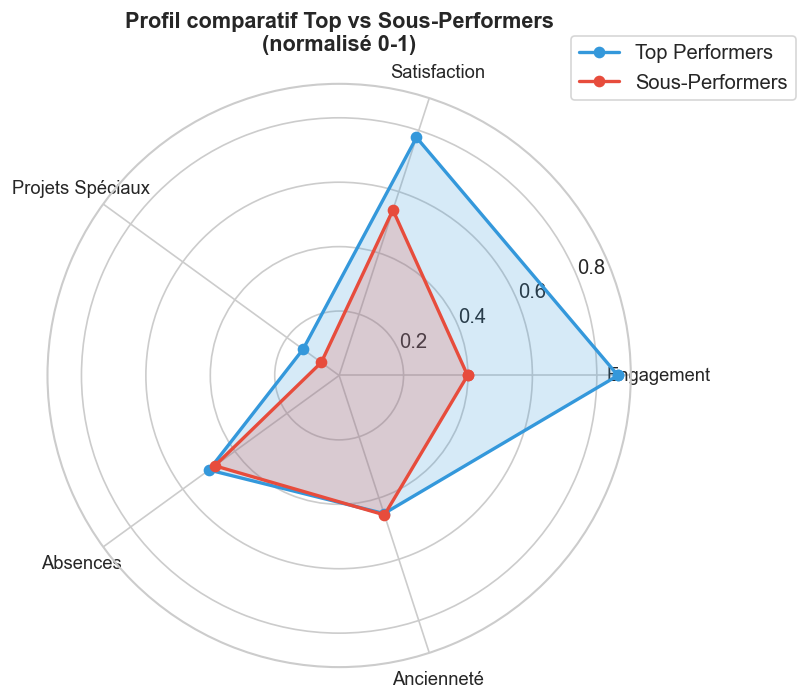

In [48]:
# ── Radar chart comparatif ────────────────────────────────────────────────────
RADAR_METRICS = ['EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount',
                 'Absences', 'Seniority']
LABELS        = ['Engagement', 'Satisfaction', 'Projets Spéciaux', 'Absences', 'Ancienneté']

def normalize(col):
    mn, mx = df[col].min(), df[col].max()
    return (df[col] - mn) / (mx - mn + 1e-9)

top_vals  = [normalize(m)[top.index].mean()  for m in RADAR_METRICS]
sous_vals = [normalize(m)[sous.index].mean() for m in RADAR_METRICS]

N      = len(LABELS)
angles = [n / N * 2 * np.pi for n in range(N)] + [0]
top_vals  = top_vals  + [top_vals[0]]
sous_vals = sous_vals + [sous_vals[0]]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
ax.plot(angles, top_vals,  'o-', lw=2, color='#3498db', label='Top Performers')
ax.fill(angles, top_vals,  alpha=0.2, color='#3498db')
ax.plot(angles, sous_vals, 'o-', lw=2, color='#e74c3c', label='Sous-Performers')
ax.fill(angles, sous_vals, alpha=0.2, color='#e74c3c')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(LABELS, fontsize=11)
ax.set_title('Profil comparatif Top vs Sous-Performers\n(normalisé 0-1)',
             fontsize=13, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig('radar_top_vs_sous.png', bbox_inches='tight')
plt.show()

#### Interprétation : 
La différence la plus frappante entre les deux groupes est l'engagement : les top performers affichent un score moyen de 4,48/5 contre seulement 2,67/5 pour les sous-performers, ce qui confirme que c'est le facteur le plus discriminant. Les top performers participent également à plus de projets spéciaux (1,1 vs 0,5) et sont plus satisfaits (4,11 vs 3,16/5). Le point le plus préoccupant concerne le taux de départs : 48% des sous-performers ont quitté l'entreprise contre seulement 22% des top performers, ce qui représente un risque d'attrition majeur concentré essentiellement dans le département Production.

### 5.5 Source de recrutement & Performance

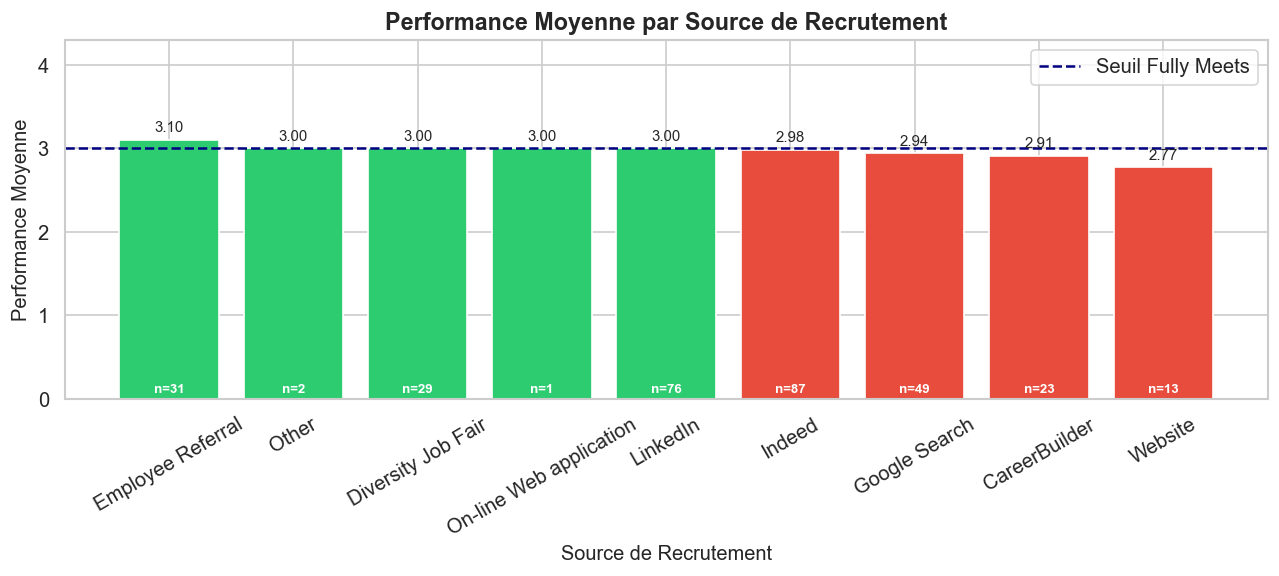

In [49]:
rec_perf = (df.groupby('RecruitmentSource')['PerformanceScore']
              .agg(['mean','count'])
              .round(2)
              .sort_values('mean', ascending=False))

colors = ['#2ecc71' if m >= 3 else '#e74c3c' for m in rec_perf['mean']]

fig, ax = plt.subplots(figsize=(11, 5))
bars = ax.bar(rec_perf.index, rec_perf['mean'], color=colors, edgecolor='white')
ax.axhline(3, color='navy', linestyle='--', lw=1.5, label='Seuil Fully Meets')
ax.bar_label(bars, padding=3, fmt='%.2f', fontsize=9)
for i, (_, row) in enumerate(rec_perf.iterrows()):
    ax.text(i, 0.07, f'n={int(row["count"])}', ha='center', fontsize=8,
            color='white', fontweight='bold')
ax.set_title('Performance Moyenne par Source de Recrutement', fontsize=14, fontweight='bold')
ax.set_xlabel('Source de Recrutement')
ax.set_ylabel('Performance Moyenne')
ax.tick_params(axis='x', rotation=30)
ax.set_ylim(0, 4.3)
ax.legend()
plt.tight_layout()
plt.savefig('insight_recrutement.png', bbox_inches='tight')
plt.show()

#### Interprétation : 
Les sources basées sur le réseau et la recommandation donnent les meilleurs résultats : Employee Referral arrive en tête avec une moyenne de 3,10, suivi de Diversity Job Fair et LinkedIn à 3,00. À l'inverse, les sources d'annonces en ligne grand public performent moins bien : Website (2,77), CareerBuilder (2,91) et Google Search (2,94) sont tous en dessous du seuil Fully Meets. LinkedIn se démarque comme la source la plus volumineuse et performante à la fois avec 76 employés recrutés à 3,00 de moyenne, ce qui en fait le meilleur compromis entre volume et qualité de recrutement.

---
## 6. Synthèse & Recommandations

In [56]:
insights = [
    {'Insight': '1. Compression centrale des évaluations',
     'Observation': '78,1% des employés sont évalués Fully Meets (243/311) ; médiane = 3,0 et moyenne = 2,98. Seulement 11,9% Exceeds et 10% en difficulté (PIP + Needs Improvement).',
     'Action Business': 'Affiner les critères d\'évaluation pour mieux différencier les profils et valoriser les vrais top performers.',
     'Priorité': '🟡 Moyen'},

    {'Insight': '2. Écarts départementaux (Performance & Salary)',
     'Observation': 'Sales affiche la moyenne la plus basse (2,77) et la plus grande dispersion (std=0,76) ; Production (2,98, n=209) concentre 67% des sous-performers. IT/IS (3,06) et Software Engineering (3,09) sur-performent mais sont 2x mieux payés (~$90k-$100k) que la Production (~$55k-$65k).',
     'Action Business': 'Coaching ciblé Production et Sales ; partager les bonnes pratiques IT/IS ; revoir l\'équité salariale à performance égale.',
     'Priorité': '🔴 Haute'},

    {'Insight': '3. Outliers Salary non corrélés à la performance',
     'Observation': '29 employés (9,3%) dépassent la borne haute de 96 837, avec des salaires jusqu\'à 250k. La corrélation Salary–Performance est de seulement r=0,13, confirmant que les hauts salaires ne garantissent pas de meilleures performances.',
     'Action Business': 'Réviser la politique salariale variable ; conditionner les augmentations aux évaluations de performance.',
     'Priorité': '🔴 Haute'},

    {'Insight': '4. Top Performers (Exceeds) - 37 employés',
     'Observation': 'Engagement moyen de 4,48/5 (vs 2,67 pour les sous-performers), satisfaction 4,11/5, 1,1 projets spéciaux en moyenne. Ancienneté optimale : 6,1 ans. Taux de départ de 22% - risque de perte de talents clés.',
     'Action Business': 'Programmes de mentorat, plans de succession et rétention via mobilité interne et reconnaissance ciblée.',
     'Priorité': '🟡 Moyen'},

    {'Insight': '5. Sous-performers (Needs Improvement + PIP) - 31 employés',
     'Observation': 'Taux de départ de 48% (vs 22% pour les top performers) ; engagement très faible à 2,67/5 et satisfaction à 3,16/5. DaysLateLast30 est le facteur le plus corrélé négativement à la performance (r=-0,75).',
     'Action Business': 'Plans d\'amélioration formels (PIP), suivi mensuel des retards, formations ciblées sur l\'engagement.',
     'Priorité': '🔴 Haute'},

    {'Insight': '6. Source de recrutement & ROI performance',
     'Observation': 'Employee Referral produit les meilleurs performers (3,10/4) ; LinkedIn offre le meilleur rapport volume/qualité (n=76, moyenne=3,00). Website (2,77) et CareerBuilder (2,91) sont en dessous du seuil Fully Meets.',
     'Action Business': 'Concentrer le budget recrutement sur Employee Referral et LinkedIn ; réduire les investissements sur Website et CareerBuilder.',
     'Priorité': '🟢 Faible'},
]

display(pd.DataFrame(insights).style
    .set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'})
    .set_table_styles([{'selector': 'th', 'props': [('text-align','left'),('font-weight','bold')]}]))

,Insight,Observation,Action Business,Priorité
0,1. Compression centrale des évaluations,"78,1% des employés sont évalués Fully Meets (243/311) ; médiane = 3,0 et moyenne = 2,98. Seulement 11,9% Exceeds et 10% en difficulté (PIP + Needs Improvement).",Affiner les critères d'évaluation pour mieux différencier les profils et valoriser les vrais top performers.,🟡 Moyen
1,2. Écarts départementaux (Performance & Salary),"Sales affiche la moyenne la plus basse (2,77) et la plus grande dispersion (std=0,76) ; Production (2,98, n=209) concentre 67% des sous-performers. IT/IS (3,06) et Software Engineering (3,09) sur-performent mais sont 2x mieux payés (~$90k-$100k) que la Production (~$55k-$65k).",Coaching ciblé Production et Sales ; partager les bonnes pratiques IT/IS ; revoir l'équité salariale à performance égale.,🔴 Haute
2,3. Outliers Salary non corrélés à la performance,"29 employés (9,3%) dépassent la borne haute de 96 837, avec des salaires jusqu'à 250k. La corrélation Salary–Performance est de seulement r=0,13, confirmant que les hauts salaires ne garantissent pas de meilleures performances.",Réviser la politique salariale variable ; conditionner les augmentations aux évaluations de performance.,🔴 Haute
3,4. Top Performers (Exceeds) - 37 employés,"Engagement moyen de 4,48/5 (vs 2,67 pour les sous-performers), satisfaction 4,11/5, 1,1 projets spéciaux en moyenne. Ancienneté optimale : 6,1 ans. Taux de départ de 22% - risque de perte de talents clés.","Programmes de mentorat, plans de succession et rétention via mobilité interne et reconnaissance ciblée.",🟡 Moyen
4,5. Sous-performers (Needs Improvement + PIP) - 31 employés,"Taux de départ de 48% (vs 22% pour les top performers) ; engagement très faible à 2,67/5 et satisfaction à 3,16/5. DaysLateLast30 est le facteur le plus corrélé négativement à la performance (r=-0,75).","Plans d'amélioration formels (PIP), suivi mensuel des retards, formations ciblées sur l'engagement.",🔴 Haute
5,6. Source de recrutement & ROI performance,"Employee Referral produit les meilleurs performers (3,10/4) ; LinkedIn offre le meilleur rapport volume/qualité (n=76, moyenne=3,00). Website (2,77) et CareerBuilder (2,91) sont en dessous du seuil Fully Meets.",Concentrer le budget recrutement sur Employee Referral et LinkedIn ; réduire les investissements sur Website et CareerBuilder.,🟢 Faible


---
## 7. Dashboard Interactif en Plotly

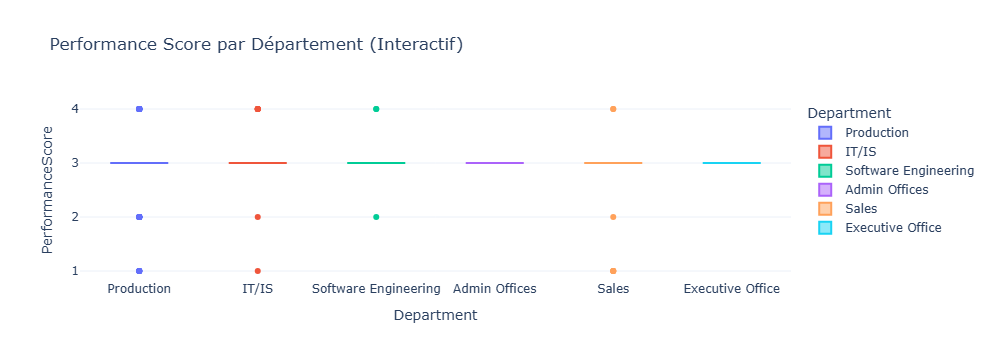

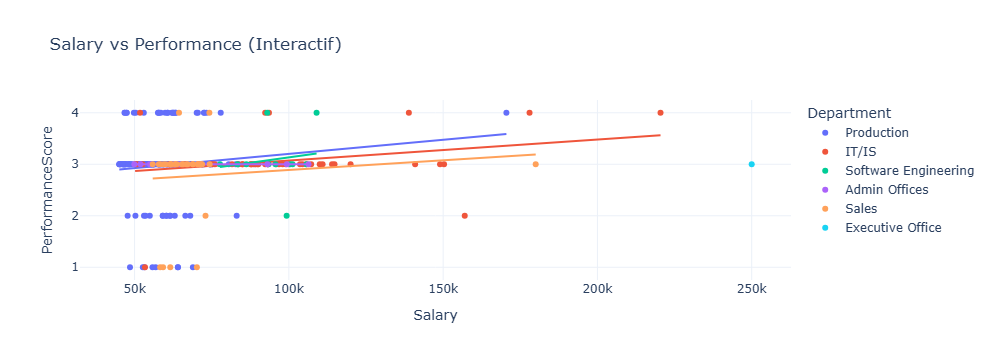

In [57]:
import plotly.express as px

fig1 = px.box(df, x='Department', y='PerformanceScore',
color='Department',
title='Performance Score par Département (Interactif)',
hover_data=['Employee_Name', 'Position', 'Salary'],
template='plotly_white')
fig1.show()

fig2 = px.scatter(df, x='Salary', y='PerformanceScore',
color='Department',
hover_data=['Employee_Name','Position','Seniority'],
title='Salary vs Performance (Interactif)',
trendline='ols',
template='plotly_white')
fig2.show()